<a href="https://colab.research.google.com/github/Baah134/Baah134/blob/main/SER_CARINE/Paper_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **FEATURE EXTRACTION**

In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
from tqdm import tqdm

# ==========================================
# 1. CONFIGURATION (Singh et al. 2023 Specs)
# ==========================================
# Paths - UPDATE THESE IF NEEDED
BASE_PATHS = {
    "TESS": "/content/drive/MyDrive/DeepLearning/External/Toronto Emotional Speech Set/TESS/TESS/",
    "SAVEE": "/content/drive/MyDrive/DeepLearning/External/SAVEE/",
    "RAVDESS": "/content/drive/MyDrive/DeepLearning/External/RAVDESS Emotional Speech Audio/audio_speech_actors_01-24/"
}

OUTPUT_PATH = "Singh_Processed_Data/"

# Audio Parameters (From Paper)
SAMPLE_RATE = 44100        # High fidelity as per paper
DURATION_SECONDS = 2.5     # Fixed duration
TOTAL_SAMPLES = int(SAMPLE_RATE * DURATION_SECONDS) # 110,250 samples

# Feature Extraction
N_MFCC = 40                # Standard for CNN inputs
HOP_LENGTH = 512
N_FFT = 2048

# Augmentation
NOISE_FACTOR = 0.005       # Amplitude of white noise

# Labels (0-7)
EMOTION_MAP = {
    'neutral': 0,
    'calm': 1,
    'happy': 2,
    'sad': 3,
    'angry': 4,
    'fear': 5,
    'disgust': 6,
    'surprise': 7
}

# ==========================================
# 2. DATA PARSERS (Path & Speaker Extraction)
# ==========================================

def parse_tess(base_path):
    print("Parsing TESS...")
    data = []
    if not os.path.exists(base_path):
        print(f"Warning: TESS path not found: {base_path}")
        return pd.DataFrame()

    # TESS structure: /TESS/OAF_Fear/OAF_fear_01.wav
    for folder in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder)
        if not os.path.isdir(folder_path): continue

        for file in os.listdir(folder_path):
            if not file.endswith('.wav'): continue

            # Logic from your snippet + Speaker Extraction
            # Filename: OAF_fear_01.wav
            parts = file.split('.')[0].split('_')

            # Speaker: 'OAF' or 'YAF' (Always 1st part)
            speaker = f"TESS_{parts[0]}"

            # Emotion: usually 2nd part, handle 'ps' for surprise
            emotion_code = parts[2] if len(parts) > 2 else parts[1] # Robustness check

            if emotion_code == 'ps':
                emotion = 'surprise'
            else:
                emotion = emotion_code.lower()

            if emotion in EMOTION_MAP:
                data.append({
                    'Path': os.path.join(folder_path, file),
                    'Emotion': emotion,
                    'SpeakerID': speaker,
                    'Source': 'TESS'
                })
    return pd.DataFrame(data)

def parse_savee(base_path):
    print("Parsing SAVEE...")
    data = []
    if not os.path.exists(base_path):
        print(f"Warning: SAVEE path not found: {base_path}")
        return pd.DataFrame()

    # SAVEE structure: Sometimes flat, sometimes folders (DC, JE, JK, KL)
    # We scan recursively to be safe
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if not file.endswith('.wav'): continue

            # Speaker Logic: Usually folder name or filename prefix
            # Assuming folder structure: /SAVEE/DC/a01.wav -> Speaker DC
            folder_name = os.path.basename(root)

            if folder_name in ['DC', 'JE', 'JK', 'KL']:
                speaker = f"SAVEE_{folder_name}"
            else:
                # If flat file: DC_a01.wav (Extract first 2 chars)
                # Or if just a01.wav, we might lose speaker info without folder.
                # Assuming standard SAVEE download often has prefix.
                # Fallback: Use folder name even if generic
                speaker = f"SAVEE_{folder_name}"

            # Emotion Logic (from your snippet)
            # Filename: a01.wav -> 'a' is anger
            # Remove digits and extension
            filename_clean = file.split('.')[0] # a01
            code = ''.join([i for i in filename_clean if not i.isdigit() and i != '_'])

            # Handle SAVEE specific codes (e.g. 'sa' vs 'a')
            # Extract last part if there's a prefix like DC_a01
            if '_' in file:
                code = file.split('_')[1]
                code = ''.join([i for i in code.split('.')[0] if not i.isdigit()])

            emo_lookup = {
                'a': 'angry', 'd': 'disgust', 'f': 'fear',
                'h': 'happy', 'n': 'neutral', 'sa': 'sad', 'su': 'surprise'
            }

            emotion = emo_lookup.get(code)

            if emotion and emotion in EMOTION_MAP:
                data.append({
                    'Path': os.path.join(root, file),
                    'Emotion': emotion,
                    'SpeakerID': speaker,
                    'Source': 'SAVEE'
                })
    return pd.DataFrame(data)

def parse_ravdess(base_path):
    print("Parsing RAVDESS...")
    data = []
    if not os.path.exists(base_path):
        print(f"Warning: RAVDESS path not found: {base_path}")
        return pd.DataFrame()

    # RAVDESS structure: /Actor_01/03-01-05-01-01-01-01.wav
    for actor_dir in os.listdir(base_path):
        actor_path = os.path.join(base_path, actor_dir)
        if not os.path.isdir(actor_path): continue

        for file in os.listdir(actor_path):
            if not file.endswith('.wav'): continue

            parts = file.split('.')[0].split('-')
            if len(parts) < 7: continue

            # Emotion: 3rd part (Index 2)
            # 01=neutral, 02=calm, 03=happy, 04=sad, 05=angry, 06=fear, 07=disgust, 08=surprise
            emo_code = int(parts[2])
            emo_map_rav = {
                1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad',
                5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'
            }
            emotion = emo_map_rav.get(emo_code)

            # Speaker: 7th part (Index 6) -> "01", "24"
            actor_id = parts[6]
            speaker = f"RAV_{actor_id}"

            if emotion in EMOTION_MAP:
                data.append({
                    'Path': os.path.join(actor_path, file),
                    'Emotion': emotion,
                    'SpeakerID': speaker,
                    'Source': 'RAVDESS'
                })
    return pd.DataFrame(data)

# ==========================================
# 3. SIGNAL PROCESSING FUNCTIONS
# ==========================================

def get_mfcc(y, sr):
    """Compute MFCCs and transpose to (Bands, Time)"""
    # 1. MFCC Extraction
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH)
    # 2. Log Scale (Standard for Deep Learning)
    # librosa.feature.mfcc returns already suitable values, but log-mel is often used.
    # The paper mentions 'Cepstral Coefficients', standard implementation is usually fine.
    return mfcc

def process_audio_file(file_path):
    """
    Reads, Resamples (44.1k), Pads/Truncates (2.5s), Augments.
    Returns: List of MFCC arrays (Clean, Noisy)
    """
    try:
        # 1. Load & Resample (Critical: Singh et al. used 44.1 kHz)
        y, sr = librosa.load(file_path, sr=SAMPLE_RATE)

        # 2. Duration Standardization (2.5s)
        if len(y) > TOTAL_SAMPLES:
            # Truncate: take the center (most emotional part)
            start = (len(y) - TOTAL_SAMPLES) // 2
            y_fixed = y[start : start + TOTAL_SAMPLES]
        else:
            # Pad: Append zeros
            padding = TOTAL_SAMPLES - len(y)
            y_fixed = np.pad(y, (0, padding), 'constant')

        # 3. Augmentation (White Noise)
        noise_amp = NOISE_FACTOR * np.random.uniform() * np.amax(y_fixed)
        y_noisy = y_fixed + noise_amp * np.random.normal(size=y_fixed.shape[0])

        # 4. Feature Extraction
        mfcc_clean = get_mfcc(y_fixed, sr)
        mfcc_noisy = get_mfcc(y_noisy, sr)

        return [mfcc_clean, mfcc_noisy]

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# ==========================================
# 4. MAIN PIPELINE
# ==========================================

if __name__ == "__main__":
    if not os.path.exists(OUTPUT_PATH):
        os.makedirs(OUTPUT_PATH)

    # --- Step 1: Create Master DataFrame ---
    print("--- Phase 1: Indexing Files ---")
    df_tess = parse_tess(BASE_PATHS["TESS"])
    df_savee = parse_savee(BASE_PATHS["SAVEE"])
    df_ravdess = parse_ravdess(BASE_PATHS["RAVDESS"])

    master_df = pd.concat([df_tess, df_savee, df_ravdess], ignore_index=True)

    print("\nDataset Summary:")
    print(master_df['Source'].value_counts())
    print("\nEmotion Distribution:")
    print(master_df['Emotion'].value_counts())

    # --- Step 2: Processing Loop ---
    print("\n--- Phase 2: Processing Audio (This may take a while) ---")

    X_data = []
    Y_data = []
    S_data = [] # Speaker IDs

    # Using tqdm for progress bar
    for index, row in tqdm(master_df.iterrows(), total=master_df.shape[0]):
        path = row['Path']
        emotion_str = row['Emotion']
        speaker_id = row['SpeakerID']

        # Convert Emotion String to Int
        label = EMOTION_MAP[emotion_str]

        # Process (Get Clean and Noisy versions)
        features = process_audio_file(path)

        if features is not None:
            # Append Clean
            X_data.append(features[0])
            Y_data.append(label)
            S_data.append(speaker_id)

            # Append Noisy (Augmentation)
            X_data.append(features[1])
            Y_data.append(label)
            S_data.append(speaker_id) # Same speaker for augmented file!

    # --- Step 3: Final Formatting & Saving ---
    print("\n--- Phase 3: saving to .npy ---")

    # Convert to Numpy Arrays
    X = np.array(X_data)
    Y = np.array(Y_data)
    S = np.array(S_data)

    # Reshape X for CNN: (N, 40, Time, 1)
    # Current shape is (N, 40, Time). We add the channel dimension.
    X = X[..., np.newaxis]

    print(f"Final X Shape: {X.shape}")
    print(f"Final Y Shape: {Y.shape}")
    print(f"Final S Shape: {S.shape}")

    # Save
    np.save(os.path.join(OUTPUT_PATH, "X_singh.npy"), X)
    np.save(os.path.join(OUTPUT_PATH, "Y_singh.npy"), Y)
    np.save(os.path.join(OUTPUT_PATH, "S_singh.npy"), S)

    print(f"\nSuccess! Data saved to {OUTPUT_PATH}")
    print("Ready for 'Strict Speaker Split' Training.")

--- Phase 1: Indexing Files ---
Parsing TESS...
Parsing SAVEE...
Parsing RAVDESS...

Dataset Summary:
Source
TESS       2800
RAVDESS    1440
SAVEE       480
Name: count, dtype: int64

Emotion Distribution:
Emotion
angry       652
sad         652
disgust     652
fear        652
surprise    652
happy       652
neutral     616
calm        192
Name: count, dtype: int64

--- Phase 2: Processing Audio (This may take a while) ---


100%|██████████| 4720/4720 [31:13<00:00,  2.52it/s]



--- Phase 3: saving to .npy ---
Final X Shape: (9440, 40, 216, 1)
Final Y Shape: (9440,)
Final S Shape: (9440,)

Success! Data saved to Singh_Processed_Data/
Ready for 'Strict Speaker Split' Training.


In [ ]:
!zip -r Singh_Processed_Data.zip Singh_Processed_Data/

  adding: Singh_Processed_Data/ (stored 0%)
  adding: Singh_Processed_Data/X_singh.npy (deflated 27%)
  adding: Singh_Processed_Data/Y_singh.npy (deflated 98%)
  adding: Singh_Processed_Data/S_singh.npy (deflated 100%)


In [2]:
!unzip -q Singh_Processed_Data.zip -d ./

# **RANDOM SPLIT**

In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. CONFIGURATION
# ==========================================
DATA_PATH = "Singh_Processed_Data/"
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 0.001
TEST_SIZE = 0.25 # Paper specified 75/25 split (Section 3.2)

EMOTION_LABELS = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fear', 'disgust', 'surprise']
NUM_CLASSES = len(EMOTION_LABELS)

# ==========================================
# 2. PREPROCESSING HELPERS (NEW)
# ==========================================
def clean_and_normalize(X_train, X_test):
    """
    1. Replaces NaNs/Infs with 0.
    2. Applies Standard Scaling (Zero Mean, Unit Variance) based on TRAIN stats.
    """
    print("Sanitizing data (NaN check)...")
    # 1. Replace NaNs and Infinity with 0
    X_train = np.nan_to_num(X_train)
    X_test = np.nan_to_num(X_test)

    print("Normalizing data (StandardScaler)...")
    # 2. Calculate Mean and Std from TRAIN set only (Shape: N, 40, 216, 1)
    # We normalize across the entire dataset (global scaling) or per feature channel.
    # For CNNs, global scaling or per-frequency-bin scaling is common.
    # Here we calculate statistics for each MFCC bin (axis 1) across all samples and time.

    # Mean/Std shape: (1, 40, 1, 1) broadcastable
    mean = np.mean(X_train, axis=(0, 2, 3), keepdims=True)
    std = np.std(X_train, axis=(0, 2, 3), keepdims=True)

    # Avoid division by zero
    std = np.where(std == 0, 1.0, std)

    X_train_norm = (X_train - mean) / std
    X_test_norm = (X_test - mean) / std

    return X_train_norm, X_test_norm

# ==========================================
# 3. MODEL ARCHITECTURE (Singh et al. 2023)
# ==========================================
class SequenceAttention(layers.Layer):
    """
    Custom Attention Layer that allows the model to weight the sequence
    before passing it to the final LSTM.
    """
    def __init__(self, **kwargs):
        super(SequenceAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], 1), initializer='glorot_uniform', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[1], 1), initializer='zeros', trainable=True)
        super(SequenceAttention, self).build(input_shape)

    def call(self, x):
        # x shape: (batch, time, features)
        e = K.tanh(K.dot(x, self.W) + self.b)
        e = K.squeeze(e, axis=-1)
        alpha = K.softmax(e)
        alpha = K.expand_dims(alpha, axis=-1)
        return x * alpha

def build_singh_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # --- PART A: CNN-2D Blocks (Spatial) ---
    x = inputs
    # 4 Identical Convolution Blocks
    for _ in range(4):
        x = layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(0.2)(x)

    # --- PART B: Reshape for LSTM ---
    # Permute to (Batch, Time, Freq, Channels)
    x = layers.Permute((2, 1, 3))(x)
    # Flatten Freq and Channels to get (Batch, Time, Features)
    bs, t, f, c = x.shape
    x = layers.Reshape((-1, x.shape[2] * x.shape[3]))(x)

    # --- PART C: LSTM + Attention (Temporal) ---
    x = layers.LSTM(32, return_sequences=True)(x)
    x = SequenceAttention()(x) # Weights the important time steps
    x = layers.LSTM(32, return_sequences=False)(x) # Consolidates to vector

    # --- PART D: Classifier ---
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs, name="Singh_Replication_Model")
    return model

# ==========================================
# 4. MAIN EXECUTION
# ==========================================
if __name__ == "__main__":

    # 1. Load Data
    print("Loading Data...")
    try:
        X = np.load(os.path.join(DATA_PATH, "X_singh.npy"))
        y = np.load(os.path.join(DATA_PATH, "Y_singh.npy"))
        print(f"Loaded Data: X={X.shape}, Y={y.shape}")
    except FileNotFoundError:
        print(f"Error: Data not found in {DATA_PATH}. Run the feature extraction script first.")
        exit()

    # 2. Random Split (75% Train, 25% Test)
    print(f"Splitting Data (Test Size: {TEST_SIZE})...")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42, shuffle=True)

    # 3. CLEAN AND NORMALIZE (Added Step)
    X_train, X_test = clean_and_normalize(X_train, X_test)

    print(f"Train Set: {X_train.shape}")
    print(f"Test Set:  {X_test.shape}")

    # 4. Build Model
    input_shape = X_train.shape[1:]
    model = build_singh_model(input_shape, NUM_CLASSES)
    model.summary()

    # 5. Compile
    optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # 6. Callbacks
    checkpoint = callbacks.ModelCheckpoint("best_singh_model.keras", monitor='val_accuracy', save_best_only=True, verbose=1)
    early_stop = callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    # 7. Train
    print("\nStarting Replication Training...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,

    )

    # 8. Evaluation & Viz
    print("\nEvaluating Model...")
    loss, acc = model.evaluate(X_test, y_test)
    print(f"\nREPLICATION RESULT: Test Accuracy = {acc*100:.2f}%")

    y_pred = np.argmax(model.predict(X_test), axis=1)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=EMOTION_LABELS))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=EMOTION_LABELS, yticklabels=EMOTION_LABELS)
    plt.title('Confusion Matrix (Normalized)')
    plt.show()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Test')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

Loading Data...
Loaded Data: X=(9440, 40, 216, 1), Y=(9440,)
Splitting Data (Test Size: 0.25)...
Sanitizing data (NaN check)...
Normalizing data (StandardScaler)...
Train Set: (7080, 40, 216, 1)
Test Set:  (2360, 40, 216, 1)


Model: "Singh_Replication_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 40, 216, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 40, 216, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 40, 216, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 40, 216, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 20, 108, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 20, 108, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 20, 108, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 20, 108, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 20, 108, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 10, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 10, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 10, 54, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 10, 54, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 10, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 5, 27, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 5, 27, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 5, 27, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 5, 27, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 5, 27, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 2, 13, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 2, 13, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute_1 (Permute)             │ (None, 13, 2, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 13, 128)        │             

 Total params: 141,685 (553.46 KB)

 Trainable params: 141,173 (551.46 KB)

 Non-trainable params: 512 (2.00 KB)


Starting Replication Training...
Epoch 1/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.3726 - loss: 1.7336 - val_accuracy: 0.2941 - val_loss: 1.9946
Epoch 2/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.7119 - loss: 0.8040 - val_accuracy: 0.7034 - val_loss: 0.8300
Epoch 3/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.7573 - loss: 0.6649 - val_accuracy: 0.7568 - val_loss: 0.6803
Epoch 4/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.7915 - loss: 0.5839 - val_accuracy: 0.7530 - val_loss: 0.6713
Epoch 5/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.8042 - loss: 0.5276 - val_accuracy: 0.8051 - val_loss: 0.5235
Epoch 6/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.8158 - loss: 0.4842 - val_accuracy: 0.7847 - val_loss: 0.5818
Epoch 7/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.8398 - loss: 0.4509 - val_accuracy: 0.7979 - val_loss: 0.5438
Epoch 8/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step -

KeyboardInterrupt: 

# **STRICT SPEAKER SPLIT**

Loading Data...
Total Samples: 9440
Strict Split Created:
  Train Set: (5760, 40, 216, 1) (Includes TESS_OAF)
  Val Set:   (640, 40, 216, 1)
  TEST SET:  (3040, 40, 216, 1) (RAV_23/24, SAV_DC/JE, TESS_YAF)
Normalizing Data...

Starting Strict Split Training...
Epoch 1/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.2808 - loss: 1.8443 - val_accuracy: 0.2313 - val_loss: 2.0078 - learning_rate: 0.0010
Epoch 2/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.6351 - loss: 1.0548 - val_accuracy: 0.2313 - val_loss: 1.9394 - learning_rate: 0.0010
Epoch 3/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.7005 - loss: 0.8542 - val_accuracy: 0.3625 - val_loss: 1.7101 - learning_rate: 0.0010
Epoch 4/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.7308 - loss: 0.7528 - val_accuracy: 0.4062 - val_loss: 1.6817 - learning_rate: 0.0010
Epoch 5/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.7508 - loss: 0.6811 - val_accuracy: 0.4047 - val_loss: 1.58

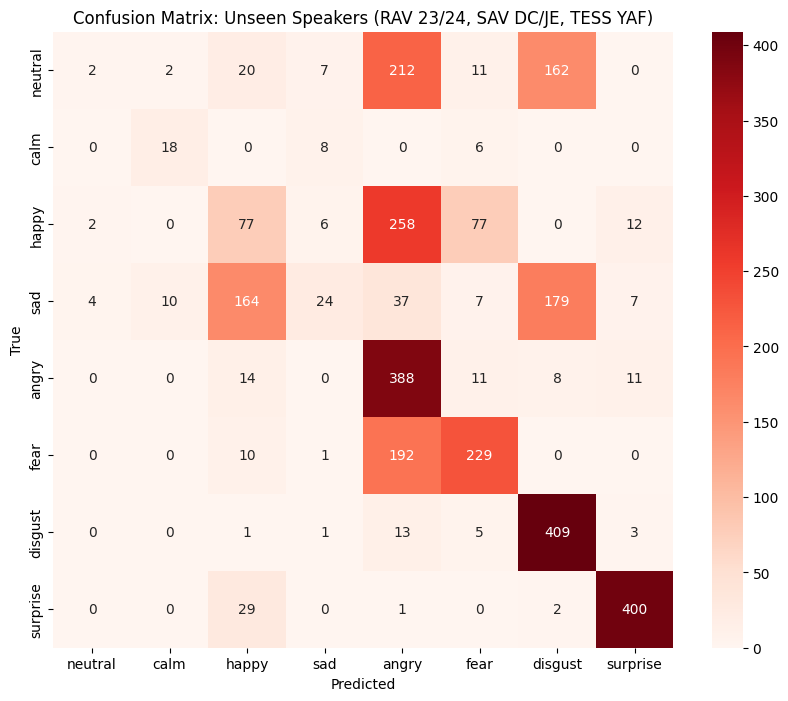

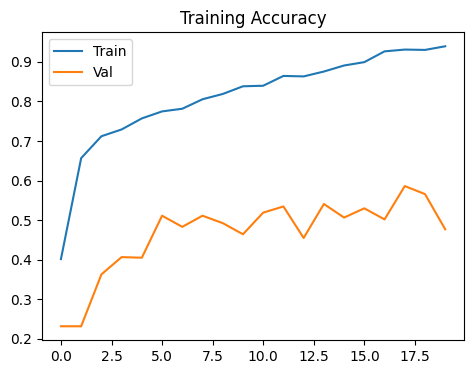

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, backend as K
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. CONFIGURATION
# ==========================================
DATA_PATH = "Singh_Processed_Data/"
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001

# --- STRICT SPLIT CONFIGURATION ---
# TEST Set: 2 RAVDESS, 2 SAVEE, 1 TESS
# TRAIN Set: Everyone else (Includes RAV 01-22, SAV JK/KL, and TESS_OAF)
TEST_SPEAKERS = [
    'RAV_23', 'RAV_24',       # 2 RAVDESS Actors
    'SAVEE_DC', 'SAVEE_JE',   # 2 SAVEE Actors
    'TESS_YAF'                # 1 TESS Actor (Younger Actress)
    # TESS_OAF (Older Actress) remains in TRAIN set to help model learn TESS characteristics
]

EMOTION_LABELS = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fear', 'disgust', 'surprise']
NUM_CLASSES = len(EMOTION_LABELS)

# ==========================================
# 2. DATA LOADING & SPLITTING UTILS
# ==========================================
def load_and_split_strict(data_path, test_speakers):
    print("Loading Data...")
    try:
        X = np.load(os.path.join(data_path, "X_singh.npy"))
        y = np.load(os.path.join(data_path, "Y_singh.npy"))
        S = np.load(os.path.join(data_path, "S_singh.npy"))
    except FileNotFoundError:
        print("Error: Data files not found. Run extraction script first.")
        exit()

    print(f"Total Samples: {len(y)}")

    # Create Boolean Mask
    test_mask = np.isin(S, test_speakers)
    train_mask = ~test_mask

    X_train, y_train = X[train_mask], y[train_mask]
    X_test, y_test = X[test_mask], y[test_mask]

    # Check split sizes
    if len(X_train) == 0:
        print("CRITICAL ERROR: Training set is empty! Check your TEST_SPEAKERS list.")
        exit()

    # Validation Split (10% of Train)
    val_split_idx = int(len(X_train) * 0.9)
    X_train_final = X_train[:val_split_idx]
    y_train_final = y_train[:val_split_idx]
    X_val = X_train[val_split_idx:]
    y_val = y_train[val_split_idx:]

    print(f"Strict Split Created:")
    print(f"  Train Set: {X_train_final.shape} (Includes TESS_OAF)")
    print(f"  Val Set:   {X_val.shape}")
    print(f"  TEST SET:  {X_test.shape} (RAV_23/24, SAV_DC/JE, TESS_YAF)")

    return X_train_final, y_train_final, X_val, y_val, X_test, y_test

def clean_and_normalize(X_train, X_val, X_test):
    """
    Standardize based on TRAIN statistics only.
    """
    print("Normalizing Data...")
    X_train = np.nan_to_num(X_train)
    X_val = np.nan_to_num(X_val)
    X_test = np.nan_to_num(X_test)

    # Calculate Mean/Std from TRAIN only (per-channel)
    mean = np.mean(X_train, axis=(0, 2, 3), keepdims=True)
    std = np.std(X_train, axis=(0, 2, 3), keepdims=True)
    std = np.where(std == 0, 1.0, std)

    X_train = (X_train - mean) / std
    X_val = (X_val - mean) / std
    X_test = (X_test - mean) / std

    return X_train, X_val, X_test

# ==========================================
# 3. MODEL ARCHITECTURE (Singh et al. 2023)
# ==========================================
class SequenceAttention(layers.Layer):
    def __init__(self, **kwargs):
        super(SequenceAttention, self).__init__(**kwargs)
    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], 1), initializer='glorot_uniform', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[1], 1), initializer='zeros', trainable=True)
        super(SequenceAttention, self).build(input_shape)
    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        e = K.squeeze(e, axis=-1)
        alpha = K.softmax(e)
        alpha = K.expand_dims(alpha, axis=-1)
        return x * alpha

def build_singh_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = inputs
    # 4 CNN Blocks
    for _ in range(4):
        x = layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(0.2)(x)

    # Reshape for LSTM
    x = layers.Permute((2, 1, 3))(x)
    x = layers.Reshape((-1, x.shape[2] * x.shape[3]))(x)

    # LSTM + Attention
    x = layers.LSTM(32, return_sequences=True)(x)
    x = SequenceAttention()(x)
    x = layers.LSTM(32, return_sequences=False)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs=inputs, outputs=outputs, name="Singh_Strict_Split")

# ==========================================
# 4. MAIN EXPERIMENT
# ==========================================
if __name__ == "__main__":

    # 1. Load & Split
    X_train, y_train, X_val, y_val, X_test, y_test = load_and_split_strict(DATA_PATH, TEST_SPEAKERS)

    # 2. Normalize
    X_train, X_val, X_test = clean_and_normalize(X_train, X_val, X_test)

    # 3. Build & Compile
    model = build_singh_model(X_train.shape[1:], NUM_CLASSES)
    model.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # 4. Train
    print("\nStarting Strict Split Training...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[
            callbacks.ModelCheckpoint("best_singh_strict.keras", monitor='val_accuracy', save_best_only=True),
            callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
            callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
        ]
    )

    # 5. Final Evaluation
    print("\n--- EXPERIMENT RESULTS ---")
    loss, acc = model.evaluate(X_test, y_test)
    print(f"Strict Split Test Accuracy: {acc*100:.2f}%")

    # 6. Detailed Analysis
    y_pred = np.argmax(model.predict(X_test), axis=1)

    print("\nClassification Report (Unseen Speakers):")
    print(classification_report(y_test, y_pred, target_names=EMOTION_LABELS))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=EMOTION_LABELS, yticklabels=EMOTION_LABELS)
    plt.title('Confusion Matrix: Unseen Speakers (RAV 23/24, SAV DC/JE, TESS YAF)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title('Training Accuracy')
    plt.legend()
    plt.show()